# HW 8 : Forward Filtering

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

df = pd.read_csv("simdata.csv")
vy = df.values[0][1:]
mF = df.values[1:][:, 1:]
T, p = vy.shape[0], mF.shape[0]
vm0 = np.zeros((p, 1))
mC0 = 0.1*np.eye(p)
amG = [np.eye(p)]*T
amW = [0.1 * np.eye(p)]*T
vV = 0.5 * np.ones(T)

In [7]:
# prepare
T, p = vy.shape[0], mF.shape[0]
ma = np.zeros((T, p))
mm = np.zeros((T, p))
mb = np.zeros((T, p))
amR = [np.eye(p)]*T
amC = [np.eye(p)]*T
    
def FF(vy, mF, vV, amG, amW, vm0, mC0):
    
    vm = vm0
    mC = mC0
    
    # main loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        mm[t, :] = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        amC[t] = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        
    return mm, amC

In [49]:
mm, mC = FF(vy, mF, vV, amG, amW, vm0, mC0)
b1, b2, b3, b4 = mm[:, 0], mm[:, 1], mm[:, 2] ,mm[:, 3]

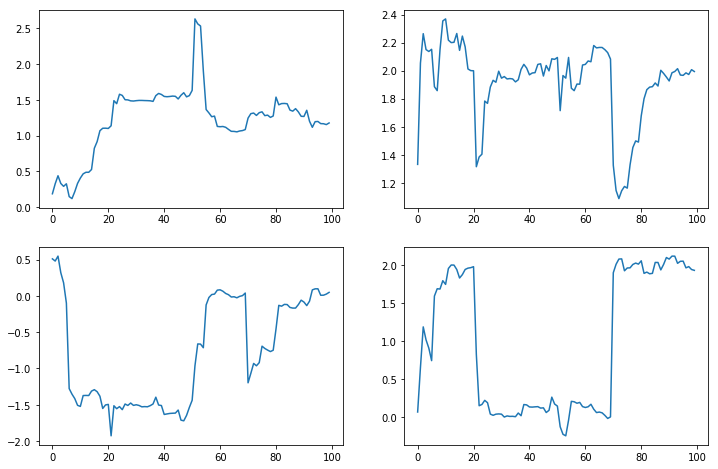

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0, 1].plot(b2)
ax[1, 0].plot(b3)
ax[1, 1].plot(b4)

# HW 9 (Q1 a): Forward Filtering and Backward Sampling 

In [98]:
nsim  = 5000
amb = [0]*(T-1)

In [99]:
def FFBS(vy, mF, vV, amG, amW, vm0, mC0):
    
    vm = vm0
    mC = mC0
    
    # ff loop
    for t in range(T):
        
        if t > 0:
            vm = mm[t-1,:].reshape([p, 1])
            mC = amC[t-1]
            
        currentF = mF[:, t].reshape([1, p])
        
        ma[t, :] = np.dot(vm.T, amG[t])
        amR[t] = np.dot(np.dot(amG[t], mC), amG[t].T) + amW[t]
        dq = np.dot(np.dot(currentF, amR[t]), currentF.T) + vV[t]
        mA = np.divide(np.dot(currentF, amR[t]), dq)
        
        m = np.dot(vm.T, amG[t]) + np.multiply(mA, vy[t] - np.dot(currentF, np.dot(vm.T, amG[t]).T))
        mm[t, :] = m
        
        C = amR[t] - np.multiply(np.dot(mA.T, mA), dq)
        amC[t] = C
    
    # BS loop
    C_float = C.astype(np.float64)
    mb = np.random.multivariate_normal(m[0].astype(np.float64), C_float, size = nsim)
    amb[T-2] = mb
    
    for t in reversed(range(T-1)):
        mB = np.dot(np.dot(amC[t], amG[t+1].T), np.linalg.inv(amR[t+1].astype(np.float64)))
        mH = amC[t]- np.dot(np.dot(mB, amR[t+1]), mB.T)
        mean = mm[t, :] + np.dot(mb - ma[t, :], mB.T)
        H_float = mH.astype(np.float64)
        mb = mean.astype(np.float64) + np.random.multivariate_normal(np.zeros(4), H_float, size = nsim)
        amb[t] = mb
        
    return amb

In [103]:
amb = FFBS(vy, mF, vV, amG, amW, vm0, mC0)

In [104]:
# aggregate

b1 = np.zeros(T)
b2 = np.zeros(T)
b3 = np.zeros(T)
b4 = np.zeros(T)
beta = [b1, b2, b3, b4]

for t in range(T-1):
    for i in range(p):
        beta[i][t] = np.mean(amb[t][:, i])

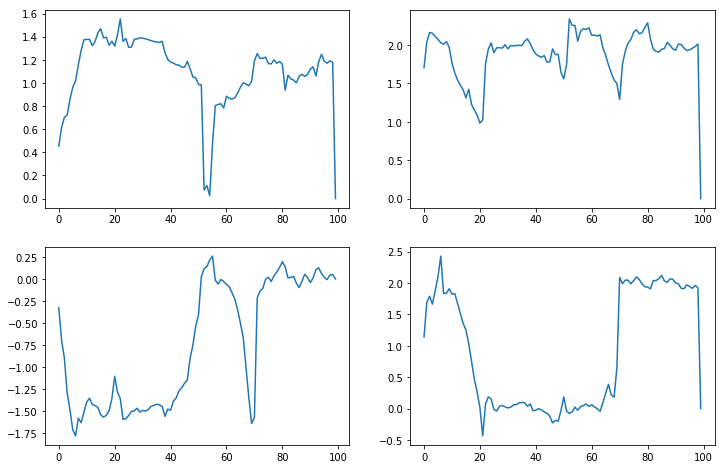

In [105]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(b1)
ax[0, 1].plot(b2)
ax[1, 0].plot(b3)
ax[1, 1].plot(b4)

# HW 9 (Q2 b) : Stochastic Volatity Model